# Toxic Text Classification

________________

here we have a huge database with about 1.8 million sample size , which got a variety comments & texts , some of them are classified as offensive & toxic 

we need to build a model able to train from this database , so he can classify the test data

# 1. import needed libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set(style="whitegrid")
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier
from nltk.corpus import stopwords
from wordcloud import WordCloud
import collections
import spacy
nlp = spacy.load('en_core_web_sm')
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import SelectPercentile , f_classif 


# 2. Read the data

In [2]:
data = pd.read_csv('../input/jigsaw-unintended-bias-in-toxicity-classification/train.csv' )  
test = pd.read_csv('../input/jigsaw-unintended-bias-in-toxicity-classification/test.csv' )  

In [3]:
data = data[:10000]

In [4]:
data.columns

Index(['id', 'target', 'comment_text', 'severe_toxicity', 'obscene',
       'identity_attack', 'insult', 'threat', 'asian', 'atheist', 'bisexual',
       'black', 'buddhist', 'christian', 'female', 'heterosexual', 'hindu',
       'homosexual_gay_or_lesbian', 'intellectual_or_learning_disability',
       'jewish', 'latino', 'male', 'muslim', 'other_disability',
       'other_gender', 'other_race_or_ethnicity', 'other_religion',
       'other_sexual_orientation', 'physical_disability',
       'psychiatric_or_mental_illness', 'transgender', 'white', 'created_date',
       'publication_id', 'parent_id', 'article_id', 'rating', 'funny', 'wow',
       'sad', 'likes', 'disagree', 'sexual_explicit',
       'identity_annotator_count', 'toxicity_annotator_count'],
      dtype='object')

In [5]:
data

id    target                                       comment_text  \
0      59848  0.000000  This is so cool. It's like, 'would you want yo...   
1      59849  0.000000  Thank you!! This would make my life a lot less...   
2      59852  0.000000  This is such an urgent design problem; kudos t...   
3      59855  0.000000  Is this something I'll be able to install on m...   
4      59856  0.893617               haha you guys are a bunch of losers.   
...      ...       ...                                                ...   
9995  254557  0.000000  IMHO, water birth research will present a coup...   
9996  254558  0.000000  Any time a pro-density opinion piece appears I...   
9997  254559  0.000000  Is that a “Taurus revolver known as “The Judge...   
9998  254560  0.000000  Motives matter. Is Mueller posting as private ...   
9999  254561  0.000000  [... continued]\nMueller is at his best with "...   

      severe_toxicity  obscene  identity_attack   insult  threat  asian  \
0            0.000000      0.0         0.000000  0.00000     0.0    NaN   
1            0.000000      0.0         0.000000  0.00000     0.0    NaN   
2            0.000000      0.0         0.000000  0.00000     0.0    NaN   
3            0.000000      0.0         0.000000  0.00000     0.0    NaN   
4            0.021277      0.0         0.021277  0.87234     0.0    0.0   
...               ...      ...              ...      ...     ...    ...   
9995         0.000000      0.0         0.000000  0.00000     0.0    NaN   
9996         0.000000      0.0         0.000000  0.00000     0.0    NaN   
9997         0.000000      0.0         0.000000  0.00000     0.0    0.0   
9998         0.000000      0.0         0.000000  0.00000     0.0    NaN   
9999         0.000000      0.0         0.000000  0.00000     0.0    NaN   

      atheist  ...  article_id    rating  funny  wow  sad  likes  disagree  \
0         NaN  ...        2006  rejected      0    0    0      0         0   
1         NaN  ...        2006  rejected      0    0    0      0         0   
2         NaN  ...        2006  rejected      0    0    0      0         0   
3         NaN  ...        2006  rejected      0    0    0      0         0   
4         0.0  ...        2006  rejected      0    0    0      1         0   
...       ...  ...         ...       ...    ...  ...  ...    ...       ...   
9995      NaN  ...       51634  approved      0    0    0      0         0   
9996      NaN  ...       51876  approved      0    0    0      6         0   
9997      0.0  ...       51627  approved      0    0    0      0         0   
9998      NaN  ...       51876  approved      0    0    0      2         0   
9999      NaN  ...       51876  approved      0    0    0      2         0   

      sexual_explicit  identity_annotator_count  toxicity_annotator_count  
0                 0.0                         0                         4  
1                 0.0                         0                         4  
2                 0.0                         0                         4  
3                 0.0                         0                         4  
4                 0.0                         4                        47  
...               ...                       ...                       ...  
9995              0.0                         0                         4  
9996              0.0                         0                         4  
9997              0.0                         4                         4  
9998              0.0                         0                         4  
9999              0.0                         0                         4  

[10000 rows x 45 columns]

____

# 3. define needed functions


In [6]:
def unique(feature) : 
    global data
    print(f'Number of unique vaure are {len(list(data[feature].unique()))} which are : \n {list(data[feature].unique())}')

def count_nulls() : 
    global data
    for col in data.columns : 
        if not data[col].isna().sum() == 0 : 
            print(f'Column   {col}    got   {data[col].isna().sum()} nulls  ,  Percentage : {round(100*data[col].isna().sum()/data.shape[0])} %')

def cplot(feature) : 
    global data
    sns.countplot(x=feature, data=data,facecolor=(0, 0, 0, 0),linewidth=5,edgecolor=sns.color_palette("dark", 3))

def encoder(feature , new_feature, drop = True) : 
    global data
    enc  = LabelEncoder()
    enc.fit(data[feature])
    data[new_feature] = enc.transform(data[feature])
    if drop == True : 
        data.drop([feature],axis=1, inplace=True)
    
def MakeCloud(text , title = 'Word Clouds' , w = 15 , h = 15):
    plt.figure(figsize=(w,h))
    plt.imshow(WordCloud(background_color="white",stopwords=set(stopwords.words('english')))
               .generate(" ".join([i for i in text.str.lower()])))
    plt.axis("off")
    plt.title(title)
    plt.show()


def SelectedData(data , feature , value , operation, selected_feature ):
    if operation==0 : 
        result = data[data[feature]==value][selected_feature]
    elif operation==1 : 
        result = data[data[feature] > value][selected_feature]
    elif operation==2 : 
        result = data[data[feature]< value][selected_feature]
    
    return result 



def CommonWords(text ,show = True , kk=10) : 
    all_words = []

    for i in range(text.shape[0]) : 
        this_phrase = list(text)[i]
        for word in this_phrase.split() : 
            all_words.append(word)
    common_words = collections.Counter(all_words).most_common()
    k=0
    word_list =[]
    for word, i in common_words : 
        if not word.lower() in  nlp.Defaults.stop_words :
            if show : 
                print(f'The word is   {word}   repeated   {i}  times')
            word_list.append(word)
            k+=1
        if k==kk : 
            break
            
    return word_list

def RemoveWords(data , feature , new_feature, words_list ) : 
    new_column = []
    for i in range(data.shape[0]) : 
        this_phrase = data[feature][i]
        new_phrase = []
        for word in this_phrase.split() : 
            if not word.lower() in words_list : 
                new_phrase.append(word)
        new_column.append(' '.join(new_phrase))
    
    data.insert(data.shape[1],new_feature,new_column)
    

    
def CountWords(text) :  
    
    all_words = []

    for i in range(text.shape[0]) : 
        this_phrase = list(text)[i]
        for word in this_phrase.split() : 
            all_words.append(word)

    print(f'Total words are {len(all_words)} words')   
    print('')
    print(f'Total unique words are {len(set(all_words))} words')   

def SlicedData(feature_list, dropna = False) : 
    global data
    if dropna :
        return data.loc[:, feature_list ].dropna()
    else : 
        return data.loc[:, feature_list ]


____


# 4. Data PreProcessing


In [7]:
data.shape

(10000, 45)

In [8]:
data.head()

id    target                                       comment_text  \
0  59848  0.000000  This is so cool. It's like, 'would you want yo...   
1  59849  0.000000  Thank you!! This would make my life a lot less...   
2  59852  0.000000  This is such an urgent design problem; kudos t...   
3  59855  0.000000  Is this something I'll be able to install on m...   
4  59856  0.893617               haha you guys are a bunch of losers.   

   severe_toxicity  obscene  identity_attack   insult  threat  asian  atheist  \
0         0.000000      0.0         0.000000  0.00000     0.0    NaN      NaN   
1         0.000000      0.0         0.000000  0.00000     0.0    NaN      NaN   
2         0.000000      0.0         0.000000  0.00000     0.0    NaN      NaN   
3         0.000000      0.0         0.000000  0.00000     0.0    NaN      NaN   
4         0.021277      0.0         0.021277  0.87234     0.0    0.0      0.0   

   ...  article_id    rating  funny  wow  sad  likes  disagree  \
0  ...        2006  rejected      0    0    0      0         0   
1  ...        2006  rejected      0    0    0      0         0   
2  ...        2006  rejected      0    0    0      0         0   
3  ...        2006  rejected      0    0    0      0         0   
4  ...        2006  rejected      0    0    0      1         0   

   sexual_explicit  identity_annotator_count  toxicity_annotator_count  
0              0.0                         0                         4  
1              0.0                         0                         4  
2              0.0                         0                         4  
3              0.0                         0                         4  
4              0.0                         4                        47  

[5 rows x 45 columns]

In [9]:
data.describe()

id        target  severe_toxicity       obscene  \
count   10000.000000  10000.000000     10000.000000  10000.000000   
mean   247306.714000      0.081725         0.003749      0.014624   
std      6749.786368      0.175589         0.021206      0.074413   
min     59848.000000      0.000000         0.000000      0.000000   
25%    244122.750000      0.000000         0.000000      0.000000   
50%    247677.500000      0.000000         0.000000      0.000000   
75%    250752.500000      0.000166         0.000000      0.000000   
max    254561.000000      1.000000         0.300000      1.000000   

       identity_attack        insult        threat        asian      atheist  \
count     10000.000000  10000.000000  10000.000000  2176.000000  2176.000000   
mean          0.016498      0.063065      0.007608     0.005146     0.008817   
std           0.065322      0.153128      0.041393     0.051778     0.087368   
min           0.000000      0.000000      0.000000     0.000000     0.000000   
25%           0.000000      0.000000      0.000000     0.000000     0.000000   
50%           0.000000      0.000000      0.000000     0.000000     0.000000   
75%           0.000000      0.000000      0.000000     0.000000     0.000000   
max           0.833333      1.000000      0.719018     1.000000     1.000000   

          bisexual  ...      parent_id    article_id         funny      wow  \
count  2176.000000  ...    5134.000000  10000.000000  10000.000000  10000.0   
mean      0.004559  ...  247695.496104  42221.700400      0.000300      0.0   
std       0.048024  ...    4089.309371   5813.156747      0.017319      0.0   
min       0.000000  ...  229671.000000   2006.000000      0.000000      0.0   
25%       0.000000  ...  244468.000000  38551.000000      0.000000      0.0   
50%       0.000000  ...  248028.500000  42482.000000      0.000000      0.0   
75%       0.000000  ...  250729.250000  46566.000000      0.000000      0.0   
max       1.000000  ...  254546.000000  51944.000000      1.000000      0.0   

           sad         likes    disagree  sexual_explicit  \
count  10000.0  10000.000000  10000.0000     10000.000000   
mean       0.0      0.992500      0.0001         0.006553   
std        0.0      1.565787      0.0100         0.046526   
min        0.0      0.000000      0.0000         0.000000   
25%        0.0      0.000000      0.0000         0.000000   
50%        0.0      0.000000      0.0000         0.000000   
75%        0.0      1.000000      0.0000         0.000000   
max        0.0     20.000000      1.0000         0.920308   

       identity_annotator_count  toxicity_annotator_count  
count              10000.000000              10000.000000  
mean                   1.700800                  8.726800  
std                   28.867882                 52.754504  
min                    0.000000                  4.000000  
25%                    0.000000                  4.000000  
50%                    0.000000                  4.000000  
75%                    0.000000                  6.000000  
max                 1842.000000               1680.000000  

[8 rows x 42 columns]

______

so we need to have a close look to some features

In [10]:
SlicedData(['obscene','identity_attack', 'insult' , 'threat']).describe()

obscene  identity_attack        insult        threat
count  10000.000000     10000.000000  10000.000000  10000.000000
mean       0.014624         0.016498      0.063065      0.007608
std        0.074413         0.065322      0.153128      0.041393
min        0.000000         0.000000      0.000000      0.000000
25%        0.000000         0.000000      0.000000      0.000000
50%        0.000000         0.000000      0.000000      0.000000
75%        0.000000         0.000000      0.000000      0.000000
max        1.000000         0.833333      1.000000      0.719018

In [11]:
SlicedData(['asian','atheist', 'bisexual' , 'black']).describe()

asian      atheist     bisexual        black
count  2176.000000  2176.000000  2176.000000  2176.000000
mean      0.005146     0.008817     0.004559     0.044732
std       0.051778     0.087368     0.048024     0.187059
min       0.000000     0.000000     0.000000     0.000000
25%       0.000000     0.000000     0.000000     0.000000
50%       0.000000     0.000000     0.000000     0.000000
75%       0.000000     0.000000     0.000000     0.000000
max       1.000000     1.000000     1.000000     1.000000

# 5. Treating Output


In [12]:
data['target'].min() , data['target'].max()

(0.0, 1.0)

In [13]:
data['target sector'] = round(data['target']*3)

In [14]:
unique('target sector')

Number of unique vaure are 4 which are : 
 [0.0, 3.0, 2.0, 1.0]


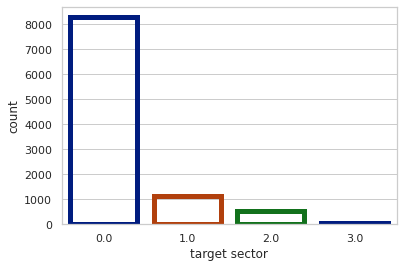

In [15]:
cplot('target sector')

In [16]:
temp_data = data[data['target sector'] > 0]['target sector']

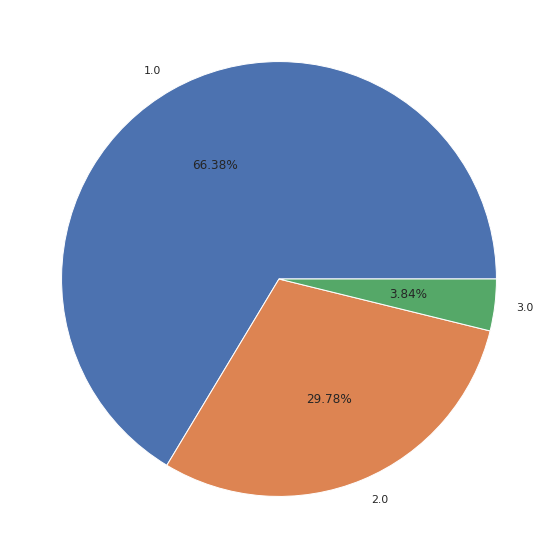

In [17]:
plt.figure(figsize=(10,10))
plt.pie(temp_data.value_counts(),labels=list(temp_data.value_counts().index),autopct ='%1.2f%%',labeldistance = 1.1)
plt.show()

In [18]:
count_nulls()

Column   asian    got   7824 nulls  ,  Percentage : 78 %
Column   atheist    got   7824 nulls  ,  Percentage : 78 %
Column   bisexual    got   7824 nulls  ,  Percentage : 78 %
Column   black    got   7824 nulls  ,  Percentage : 78 %
Column   buddhist    got   7824 nulls  ,  Percentage : 78 %
Column   christian    got   7824 nulls  ,  Percentage : 78 %
Column   female    got   7824 nulls  ,  Percentage : 78 %
Column   heterosexual    got   7824 nulls  ,  Percentage : 78 %
Column   hindu    got   7824 nulls  ,  Percentage : 78 %
Column   homosexual_gay_or_lesbian    got   7824 nulls  ,  Percentage : 78 %
Column   intellectual_or_learning_disability    got   7824 nulls  ,  Percentage : 78 %
Column   jewish    got   7824 nulls  ,  Percentage : 78 %
Column   latino    got   7824 nulls  ,  Percentage : 78 %
Column   male    got   7824 nulls  ,  Percentage : 78 %
Column   muslim    got   7824 nulls  ,  Percentage : 78 %
Column   other_disability    got   7824 nulls  ,  Percentage : 78 %
Colum

_____

# 6. Treating Text

In [19]:
data['comments']  =  data['comment_text'].str.lower()

In [20]:
SlicedData(['comment_text' , 'comments']).head(20)

comment_text  \
0   This is so cool. It's like, 'would you want yo...   
1   Thank you!! This would make my life a lot less...   
2   This is such an urgent design problem; kudos t...   
3   Is this something I'll be able to install on m...   
4                haha you guys are a bunch of losers.   
5                                ur a sh*tty comment.   
6                         hahahahahahahahhha suck it.   
7                                 FFFFUUUUUUUUUUUUUUU   
8   The ranchers seem motivated by mostly by greed...   
9   It was a great show. Not a combo I'd of expect...   
10                            Wow, that sounds great.   
11  This is a great story. Man. I wonder if the pe...   
12     This seems like a step in the right direction.   
13  It's ridiculous that these guys are being call...   
14  This story gets more ridiculous by the hour! A...   
15  I agree; I don't want to grant them the legiti...   
16  Interesting. I'll be curious to see how this w...   
17                    Awesome! I love Civil Comments!   
18  I'm glad you're working on this, and I look fo...   
19  Angry trolls, misogynists and Racists", oh my....   

                                             comments  
0   this is so cool. it's like, 'would you want yo...  
1   thank you!! this would make my life a lot less...  
2   this is such an urgent design problem; kudos t...  
3   is this something i'll be able to install on m...  
4                haha you guys are a bunch of losers.  
5                                ur a sh*tty comment.  
6                         hahahahahahahahhha suck it.  
7                                 ffffuuuuuuuuuuuuuuu  
8   the ranchers seem motivated by mostly by greed...  
9   it was a great show. not a combo i'd of expect...  
10                            wow, that sounds great.  
11  this is a great story. man. i wonder if the pe...  
12     this seems like a step in the right direction.  
13  it's ridiculous that these guys are being call...  
14  this story gets more ridiculous by the hour! a...  
15  i agree; i don't want to grant them the legiti...  
16  interesting. i'll be curious to see how this w...  
17                    awesome! i love civil comments!  
18  i'm glad you're working on this, and i look fo...  
19  angry trolls, misogynists and racists", oh my....

In [21]:
CountWords(data['comments'])

Total words are 608328 words

Total unique words are 54731 words


In [22]:
common = CommonWords(data['comments'])

The word is   people   repeated   1879  times
The word is   like   repeated   1681  times
The word is   it's   repeated   1372  times
The word is   don't   repeated   1323  times
The word is   think   repeated   1077  times
The word is   know   repeated   812  times
The word is   -   repeated   762  times
The word is   i'm   repeated   751  times
The word is   good   repeated   742  times
The word is   time   repeated   718  times


In [23]:
RemoveWords(data , 'comments' , 'filtered comments', common)
SlicedData(['comments' , 'filtered comments']).head(20)

comments  \
0   this is so cool. it's like, 'would you want yo...   
1   thank you!! this would make my life a lot less...   
2   this is such an urgent design problem; kudos t...   
3   is this something i'll be able to install on m...   
4                haha you guys are a bunch of losers.   
5                                ur a sh*tty comment.   
6                         hahahahahahahahhha suck it.   
7                                 ffffuuuuuuuuuuuuuuu   
8   the ranchers seem motivated by mostly by greed...   
9   it was a great show. not a combo i'd of expect...   
10                            wow, that sounds great.   
11  this is a great story. man. i wonder if the pe...   
12     this seems like a step in the right direction.   
13  it's ridiculous that these guys are being call...   
14  this story gets more ridiculous by the hour! a...   
15  i agree; i don't want to grant them the legiti...   
16  interesting. i'll be curious to see how this w...   
17                    awesome! i love civil comments!   
18  i'm glad you're working on this, and i look fo...   
19  angry trolls, misogynists and racists", oh my....   

                                    filtered comments  
0   this is so cool. like, 'would you want your mo...  
1   thank you!! this would make my life a lot less...  
2   this is such an urgent design problem; kudos t...  
3   is this something i'll be able to install on m...  
4                haha you guys are a bunch of losers.  
5                                ur a sh*tty comment.  
6                         hahahahahahahahhha suck it.  
7                                 ffffuuuuuuuuuuuuuuu  
8   the ranchers seem motivated by mostly by greed...  
9   it was a great show. not a combo i'd of expect...  
10                            wow, that sounds great.  
11  this is a great story. man. i wonder if the pe...  
12          this seems a step in the right direction.  
13  ridiculous that these guys are being called "p...  
14  this story gets more ridiculous by the hour! a...  
15  i agree; i want to grant them the legitimacy o...  
16  interesting. i'll be curious to see how this w...  
17                    awesome! i love civil comments!  
18  glad you're working on this, and i look forwar...  
19  angry trolls, misogynists and racists", oh my....

_____

# Cloud Words


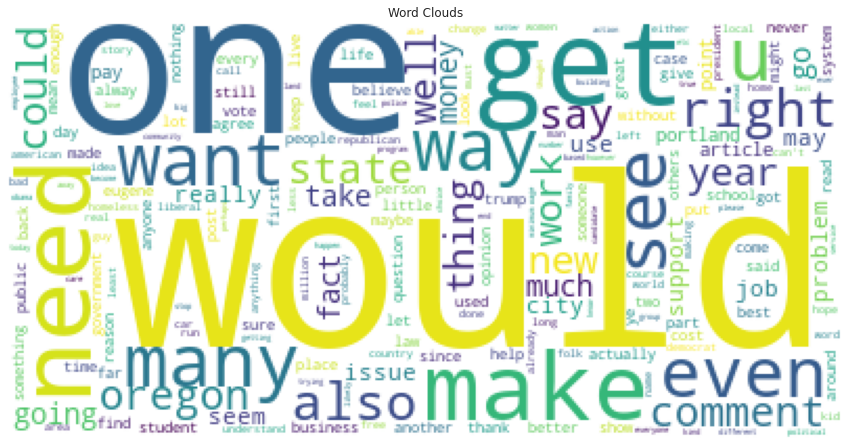

In [24]:
MakeCloud(data['filtered comments'])

In [25]:
def showclouds(n) : 
    this_list = ['asian', 'atheist', 'bisexual','black', 'buddhist', 'christian', 'female', 'heterosexual', 'hindu',
                 'homosexual_gay_or_lesbian', 'intellectual_or_learning_disability','jewish', 'latino', 'male', 'muslim',
                 'other_disability','other_gender', 'other_race_or_ethnicity', 'other_religion','other_sexual_orientation', 
                 'physical_disability','psychiatric_or_mental_illness', 'transgender', 'white' ]

    for item in this_list[n*3:(n*3)+3] : 
        this_data =  SelectedData(data ,item , 0.1 , 1 , 'filtered comments')
        print(f'for item    {item}')
        print(f'Number of selected rows {this_data.shape[0]}')
        print('common words : ')
        _ = CommonWords(this_data)
        if this_data.shape[0] >0 : 
            MakeCloud(this_data , str(f'Word Cloud for {item}'), 8 ,8)
        print('--------------------------')

____


## 'asian', 'atheist', 'bisexual'

for item    asian
Number of selected rows 27
common words : 
The word is   ,   repeated   10  times
The word is   use   repeated   7  times
The word is   chinese   repeated   7  times
The word is   trump   repeated   6  times
The word is   going   repeated   5  times
The word is   white   repeated   5  times
The word is   understand   repeated   5  times
The word is   found   repeated   5  times
The word is   species   repeated   5  times
The word is   sounds   repeated   4  times


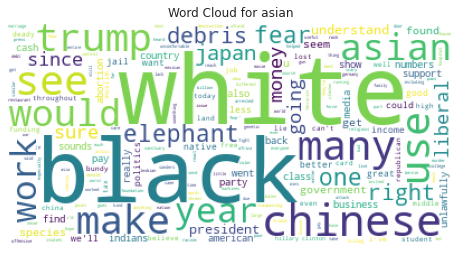

--------------------------
for item    atheist
Number of selected rows 25
common words : 
The word is   atheist   repeated   12  times
The word is   church   repeated   10  times
The word is   imago   repeated   7  times
The word is   regular   repeated   7  times
The word is   dei   repeated   6  times
The word is   churches   repeated   6  times
The word is   find   repeated   5  times
The word is   portland   repeated   5  times
The word is   religious   repeated   5  times
The word is   big   repeated   5  times


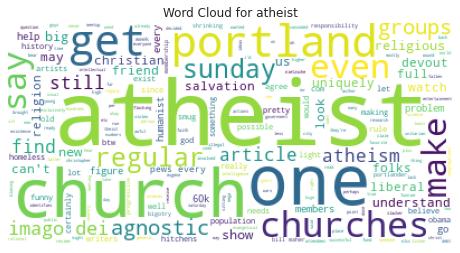

--------------------------
for item    bisexual
Number of selected rows 24
common words : 
The word is   church   repeated   15  times
The word is   lgbtq   repeated   9  times
The word is   women   repeated   9  times
The word is   evangelical   repeated   7  times
The word is   lgbt   repeated   7  times
The word is   imago   repeated   7  times
The word is   can't   repeated   6  times
The word is   jules   repeated   6  times
The word is   believe   repeated   6  times
The word is   conservative   repeated   6  times


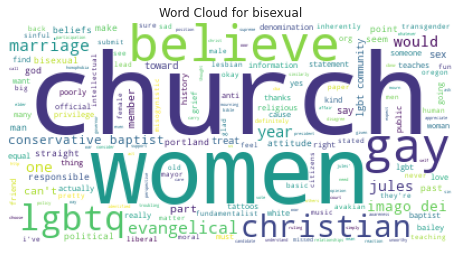

--------------------------


In [26]:
showclouds(0)

_______

## 'black', 'buddhist', 'christian'

for item    black
Number of selected rows 133
common words : 
The word is   black   repeated   96  times
The word is   white   repeated   53  times
The word is   lives   repeated   20  times
The word is   you're   repeated   19  times
The word is   police   repeated   19  times
The word is   use   repeated   18  times
The word is   .   repeated   18  times
The word is   support   repeated   18  times
The word is   far   repeated   17  times
The word is   mr.   repeated   17  times


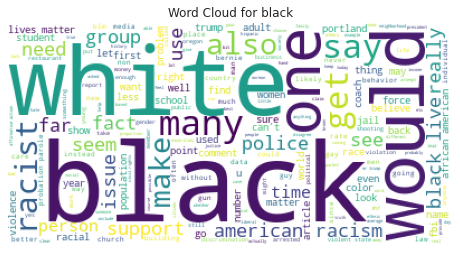

--------------------------
for item    buddhist
Number of selected rows 1
common words : 
The word is   attempt   repeated   1  times
The word is   smear   repeated   1  times
The word is   christianity   repeated   1  times
The word is   comparing   repeated   1  times
The word is   radical   repeated   1  times
The word is   islam   repeated   1  times
The word is   duly   repeated   1  times
The word is   noted.   repeated   1  times
The word is   illogic   repeated   1  times
The word is   applied   repeated   1  times


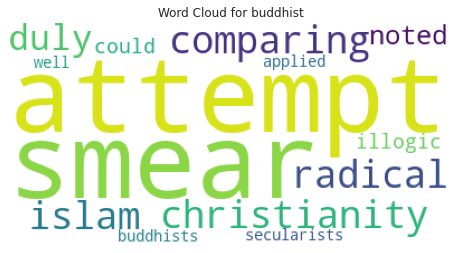

--------------------------
for item    christian
Number of selected rows 222
common words : 
The word is   church   repeated   113  times
The word is   imago   repeated   70  times
The word is   dei   repeated   51  times
The word is   christian   repeated   46  times
The word is   conservative   repeated   42  times
The word is   women   repeated   39  times
The word is   believe   repeated   30  times
The word is   bailey   repeated   30  times
The word is   jules   repeated   28  times
The word is   baptist   repeated   27  times


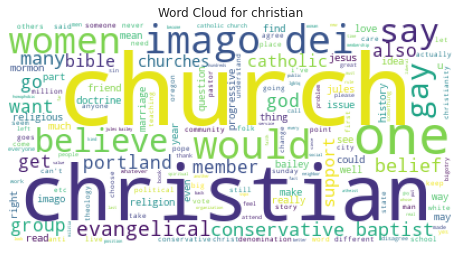

--------------------------


In [27]:
showclouds(1)

_____

## 'female', 'heterosexual', 'hindu'

for item    female
Number of selected rows 410
common words : 
The word is   women   repeated   175  times
The word is   woman   repeated   84  times
The word is   church   repeated   56  times
The word is   men   repeated   51  times
The word is   support   repeated   43  times
The word is   need   repeated   42  times
The word is   female   repeated   39  times
The word is   doesn't   repeated   38  times
The word is   want   repeated   37  times
The word is   right   repeated   36  times


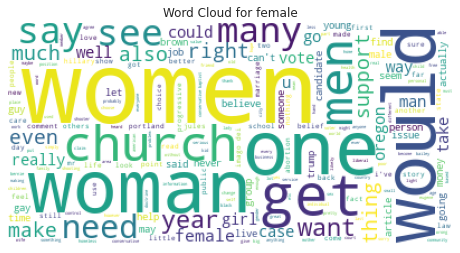

--------------------------
for item    heterosexual
Number of selected rows 25
common words : 
The word is   gay   repeated   13  times
The word is   marriage   repeated   11  times
The word is   straight   repeated   9  times
The word is   believe   repeated   9  times
The word is   conservative   repeated   8  times
The word is   imago   repeated   7  times
The word is   women   repeated   7  times
The word is   support   repeated   7  times
The word is   better   repeated   6  times
The word is   political   repeated   6  times


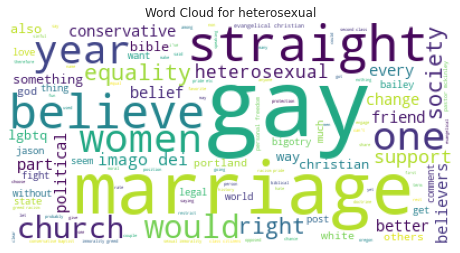

--------------------------
for item    hindu
Number of selected rows 0
common words : 
--------------------------


In [28]:
showclouds(2)

______

## 'homosexual_gay_or_lesbian', 'intellectual_or_learning_disability','jewish'

for item    homosexual_gay_or_lesbian
Number of selected rows 137
common words : 
The word is   church   repeated   67  times
The word is   gay   repeated   56  times
The word is   imago   repeated   49  times
The word is   marriage   repeated   34  times
The word is   bailey   repeated   33  times
The word is   dei   repeated   33  times
The word is   jules   repeated   33  times
The word is   believe   repeated   30  times
The word is   support   repeated   27  times
The word is   women   repeated   26  times


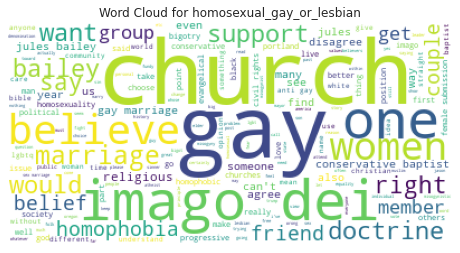

--------------------------
for item    intellectual_or_learning_disability
Number of selected rows 16
common words : 
The word is   school   repeated   7  times
The word is   need   repeated   6  times
The word is   special   repeated   6  times
The word is   social   repeated   5  times
The word is   ed   repeated   5  times
The word is   child   repeated   4  times
The word is   kids   repeated   4  times
The word is   mentally   repeated   4  times
The word is   shameless   repeated   4  times
The word is   them.   repeated   3  times


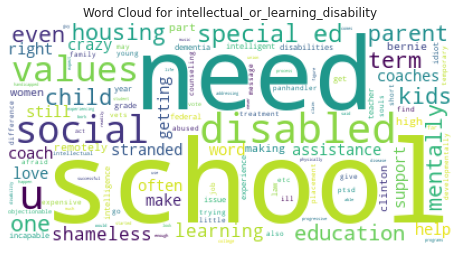

--------------------------
for item    jewish
Number of selected rows 31
common words : 
The word is   israel   repeated   18  times
The word is   jewish   repeated   18  times
The word is   state   repeated   11  times
The word is   south   repeated   11  times
The word is   palestinian   repeated   9  times
The word is   israeli   repeated   8  times
The word is   white   repeated   7  times
The word is   arab   repeated   6  times
The word is   mr.   repeated   6  times
The word is   african   repeated   5  times


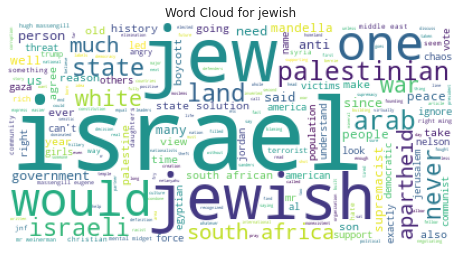

--------------------------


In [29]:
showclouds(3)

______

## 'latino', 'male', 'muslim'

for item    latino
Number of selected rows 29
common words : 
The word is   trump   repeated   14  times
The word is   white   repeated   9  times
The word is   racism   repeated   7  times
The word is   spanish   repeated   6  times
The word is   asi   repeated   6  times
The word is   program   repeated   6  times
The word is   poor   repeated   5  times
The word is   blacks   repeated   5  times
The word is   fact   repeated   5  times
The word is   black   repeated   5  times


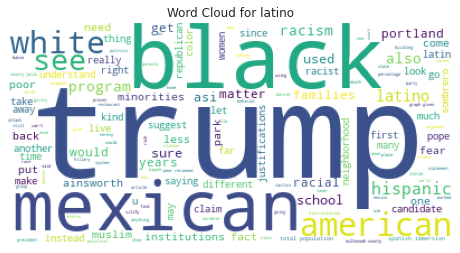

--------------------------
for item    male
Number of selected rows 395
common words : 
The word is   women   repeated   86  times
The word is   men   repeated   76  times
The word is   man   repeated   72  times
The word is   white   repeated   52  times
The word is   male   repeated   40  times
The word is   years   repeated   34  times
The word is   want   repeated   33  times
The word is   doesn't   repeated   33  times
The word is   woman   repeated   32  times
The word is   church   repeated   32  times


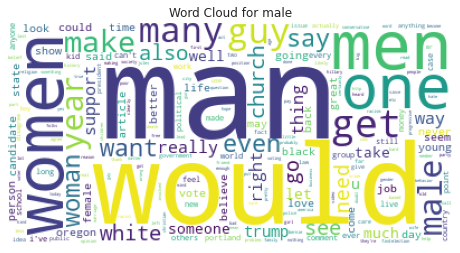

--------------------------
for item    muslim
Number of selected rows 43
common words : 
The word is   muslim   repeated   22  times
The word is   saudi   repeated   10  times
The word is   can't   repeated   9  times
The word is   law   repeated   9  times
The word is   trump   repeated   9  times
The word is   religious   repeated   9  times
The word is   malheur   repeated   8  times
The word is   muslims   repeated   7  times
The word is   extremists   repeated   7  times
The word is   reason   repeated   7  times


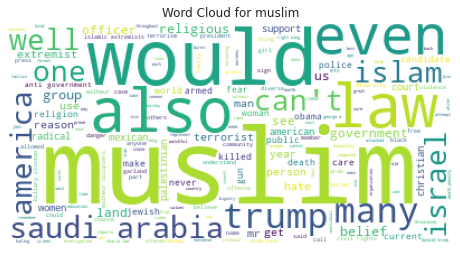

--------------------------


In [30]:
showclouds(4)

_____

## 'other_disability','other_gender', 'other_race_or_ethnicity'

for item    other_disability
Number of selected rows 9
common words : 
The word is   health   repeated   5  times
The word is   million   repeated   5  times
The word is   women   repeated   4  times
The word is   $48   repeated   4  times
The word is   impact   repeated   3  times
The word is   individual   repeated   3  times
The word is   cdc   repeated   2  times
The word is   giving   repeated   2  times
The word is   harm   repeated   2  times
The word is   known   repeated   2  times


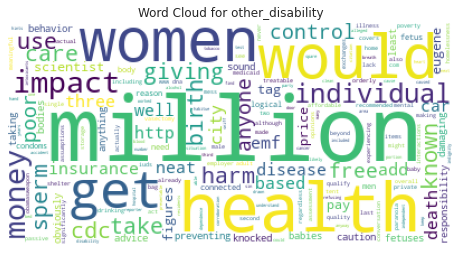

--------------------------
for item    other_gender
Number of selected rows 5
common words : 
The word is   believe   repeated   2  times
The word is   judge   repeated   2  times
The word is   university   repeated   2  times
The word is   listeners   repeated   2  times
The word is   kwax   repeated   2  times
The word is   let's   repeated   1  times
The word is   thing   repeated   1  times
The word is   clear.   repeated   1  times
The word is   (i   repeated   1  times
The word is   presume)   repeated   1  times


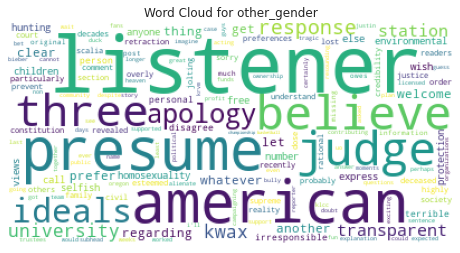

--------------------------
for item    other_race_or_ethnicity
Number of selected rows 39
common words : 
The word is   israel   repeated   9  times
The word is   white   repeated   8  times
The word is   american   repeated   6  times
The word is   well,   repeated   6  times
The word is   black   repeated   6  times
The word is   believe   repeated   6  times
The word is   arab   repeated   6  times
The word is   indians   repeated   6  times
The word is   going   repeated   5  times
The word is   war   repeated   5  times


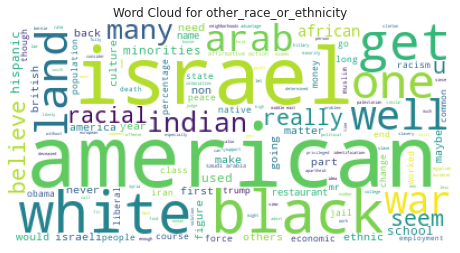

--------------------------


In [31]:
showclouds(5)

______

## 'other_religion','other_sexual_orientation'  ,'physical_disability'

for item    other_religion
Number of selected rows 47
common words : 
The word is   church   repeated   15  times
The word is   mormon   repeated   12  times
The word is   religious   repeated   11  times
The word is   conservative   repeated   10  times
The word is   .   repeated   10  times
The word is   women   repeated   9  times
The word is   dei   repeated   8  times
The word is   southern   repeated   7  times
The word is   catholic   repeated   7  times
The word is   imago   repeated   7  times


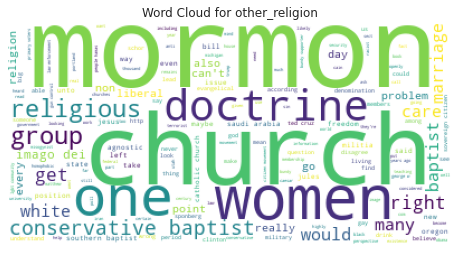

--------------------------
for item    other_sexual_orientation
Number of selected rows 7
common words : 
The word is   public   repeated   5  times
The word is   church   repeated   4  times
The word is   lives   repeated   3  times
The word is   gay   repeated   3  times
The word is   conservative   repeated   3  times
The word is   sex   repeated   3  times
The word is   nra   repeated   3  times
The word is   black   repeated   2  times
The word is   person   repeated   2  times
The word is   going   repeated   2  times


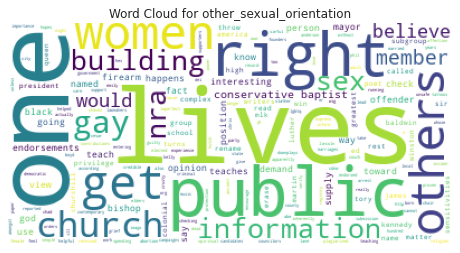

--------------------------
for item    physical_disability
Number of selected rows 13
common words : 
The word is   help   repeated   7  times
The word is   physically   repeated   6  times
The word is   need   repeated   6  times
The word is   disabled,   repeated   5  times
The word is   getting   repeated   5  times
The word is   services   repeated   4  times
The word is   legislation   repeated   3  times
The word is   treatment   repeated   3  times
The word is   understand   repeated   3  times
The word is   rent   repeated   3  times


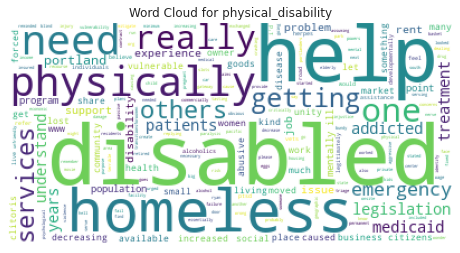

--------------------------


In [32]:
showclouds(6)

____

## 'psychiatric_or_mental_illness', 'transgender', 'white'

for item    psychiatric_or_mental_illness
Number of selected rows 98
common words : 
The word is   mental   repeated   52  times
The word is   mentally   repeated   44  times
The word is   need   repeated   31  times
The word is   ill   repeated   22  times
The word is   help   repeated   19  times
The word is   illness   repeated   19  times
The word is   support   repeated   19  times
The word is   state   repeated   18  times
The word is   oregon   repeated   17  times
The word is   individuals   repeated   17  times


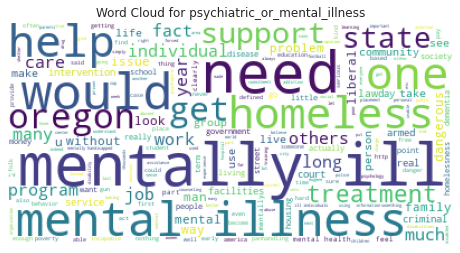

--------------------------
for item    transgender
Number of selected rows 19
common words : 
The word is   church   repeated   9  times
The word is   women   repeated   8  times
The word is   gay   repeated   8  times
The word is   lgbtq   repeated   8  times
The word is   evangelical   repeated   7  times
The word is   conservative   repeated   7  times
The word is   community   repeated   6  times
The word is   imago   repeated   6  times
The word is   couples   repeated   5  times
The word is   members   repeated   5  times


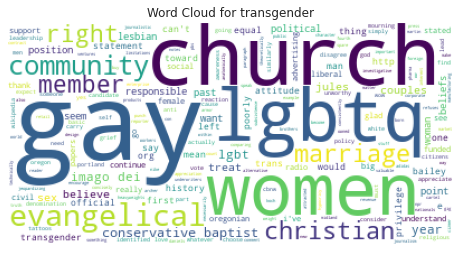

--------------------------
for item    white
Number of selected rows 158
common words : 
The word is   white   repeated   138  times
The word is   black   repeated   50  times
The word is   support   repeated   23  times
The word is   right   repeated   20  times
The word is   point   repeated   19  times
The word is   use   repeated   18  times
The word is   want   repeated   18  times
The word is   trump   repeated   18  times
The word is   political   repeated   17  times
The word is   women   repeated   17  times


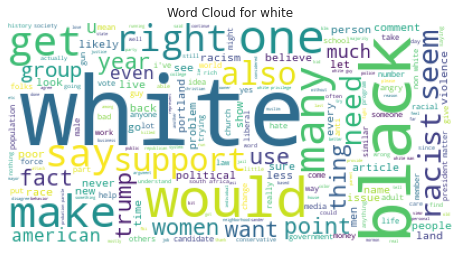

--------------------------


In [33]:
showclouds(7)

_____

# 7. Data Preparing

In [34]:
X = data['filtered comments']
y = data['target sector']

In [35]:
X.head(10)

0    this is so cool. like, 'would you want your mo...
1    thank you!! this would make my life a lot less...
2    this is such an urgent design problem; kudos t...
3    is this something i'll be able to install on m...
4                 haha you guys are a bunch of losers.
5                                 ur a sh*tty comment.
6                          hahahahahahahahhha suck it.
7                                  ffffuuuuuuuuuuuuuuu
8    the ranchers seem motivated by mostly by greed...
9    it was a great show. not a combo i'd of expect...
Name: filtered comments, dtype: object

In [36]:
y.head(10)

0    0.0
1    0.0
2    0.0
3    0.0
4    3.0
5    2.0
6    1.0
7    0.0
8    0.0
9    0.0
Name: target sector, dtype: float64

In [37]:
X.isnull().sum() , y.isnull().sum()

(0, 0)

# 8. TF Vectorizer tool

In [38]:
VecModel = TfidfVectorizer()
X = VecModel.fit_transform(X)
print(f'The new shape for X is {X.shape}')

The new shape for X is (10000, 25644)


In [39]:
FeatureSelection = SelectPercentile(score_func = f_classif, percentile=1)
X = FeatureSelection.fit_transform(X, y)

In [40]:
print('X Shape is ' , X.shape)

X Shape is  (10000, 257)


In [41]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=44, shuffle =True)

print('X_train shape is ' , X_train.shape)
print('X_test shape is ' , X_test.shape)
print('y_train shape is ' , y_train.shape)
print('y_test shape is ' , y_test.shape)

X_train shape is  (6700, 257)
X_test shape is  (3300, 257)
y_train shape is  (6700,)
y_test shape is  (3300,)


_____

# 9. Build the Model

In [42]:
GBCModel = GradientBoostingClassifier(n_estimators=500,max_depth=5,random_state=33) 
GBCModel.fit(X_train, y_train)


print('GBCModel Train Score is : ' , GBCModel.score(X_train, y_train))
print('GBCModel Test Score is : ' , GBCModel.score(X_test, y_test))


GBCModel Train Score is :  0.9477611940298507
GBCModel Test Score is :  0.8409090909090909


In [43]:
test.head()

id                                       comment_text
0  7097320  [ Integrity means that you pay your debts.]\n\...
1  7097321  This is malfeasance by the Administrator and t...
2  7097322  @Rmiller101 - Spoken like a true elitist. But ...
3  7097323  Paul: Thank you for your kind words.  I do, in...
4  7097324  Sorry you missed high school. Eisenhower sent ...

In [44]:
test['comments']  =  test['comment_text'].str.lower()
test.head()

id                                       comment_text  \
0  7097320  [ Integrity means that you pay your debts.]\n\...   
1  7097321  This is malfeasance by the Administrator and t...   
2  7097322  @Rmiller101 - Spoken like a true elitist. But ...   
3  7097323  Paul: Thank you for your kind words.  I do, in...   
4  7097324  Sorry you missed high school. Eisenhower sent ...   

                                            comments  
0  [ integrity means that you pay your debts.]\n\...  
1  this is malfeasance by the administrator and t...  
2  @rmiller101 - spoken like a true elitist. but ...  
3  paul: thank you for your kind words.  i do, in...  
4  sorry you missed high school. eisenhower sent ...

In [45]:
X_test = test['comments']

In [46]:
X_test.shape

(97320,)

In [47]:
X_test = VecModel.transform(X_test)

In [48]:
X_test.shape

(97320, 25644)

In [49]:
X_test = FeatureSelection.transform(X_test)

In [50]:
X_test.shape

(97320, 257)

In [51]:
y_pred = GBCModel.predict(X_test)
y_pred_prob = GBCModel.predict_proba(X_test)
print('Predicted Value for GBCModel is : ' , y_pred[:10])
print('Prediction Probabilities Value for GBCModel is : ' , y_pred_prob[:10])

Predicted Value for GBCModel is :  [0. 0. 1. 0. 0. 0. 3. 0. 0. 0.]
Prediction Probabilities Value for GBCModel is :  [[9.68824379e-01 1.59999012e-02 1.51594512e-02 1.62686353e-05]
 [9.39633305e-01 5.21931633e-02 8.17129667e-03 2.23549459e-06]
 [1.56386568e-01 8.13446352e-01 3.01630754e-02 4.00520171e-06]
 [8.81444026e-01 7.73828200e-02 4.11698565e-02 3.29719941e-06]
 [9.63392279e-01 3.01138314e-02 6.49080000e-03 3.08943814e-06]
 [9.02176542e-01 7.74906490e-02 2.03259025e-02 6.90620789e-06]
 [3.22927361e-04 1.66569753e-05 6.87466761e-05 9.99591669e-01]
 [5.96935186e-01 3.73657077e-01 2.94009881e-02 6.74876795e-06]
 [9.32096527e-01 5.02011654e-02 1.64267752e-02 1.27553268e-03]
 [9.25533225e-01 6.34565902e-02 1.10055871e-02 4.59785995e-06]]


## great , well done !
# the end.
---
---